# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
%config Completer.use_jedi = False


FOLDERNAME = "assignment1"
"""
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


#enter your foldername assignments/assignement1
              
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

#this will download the CIFAR-10 dataset to your drive 
#if it isnt already there

%cd drive/My\ Drive/$FOLDERNAME/CV7062610/datasets/
!bash get_datasets.sh
%cd /content
"""
PATH_= 'C:\\Users\\Ziv\\Desktop\\University\\year 3\semester 2\\computer vision\\Computer-vision-Ex-1\\' + FOLDERNAME


In [2]:
import random
import numpy as np
from CV7062610.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# New Section

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    #cifar10_dir = '/content/drive/MyDrive/' + FOLDERNAME + '/CV7062610/datasets/cifar-10-batches-py'
    cifar10_dir = PATH_ + '/CV7062610/datasets/cifar-10-batches-py'

    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `CV7062610/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file CV7062610/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from CV7062610.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.414263
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ the loss in softmax is very close to -log(M) where M the mean of P(Y=j|s_i), that is the probabilty that we choose the correct classification j for a given net input s_i, s_i = x_1\*w_1 + x_2\*w2...
since we chose random weights, the mean is 1/10 since the model just "chooses" a random class.



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from CV7062610.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.219189 analytic: -1.219189, relative error: 2.789714e-08
numerical: 3.256235 analytic: 3.256235, relative error: 1.131232e-08
numerical: 1.378338 analytic: 1.378338, relative error: 2.188605e-08
numerical: 1.411106 analytic: 1.411106, relative error: 1.389314e-08
numerical: -0.190741 analytic: -0.190741, relative error: 1.604655e-07
numerical: -3.352081 analytic: -3.352081, relative error: 3.154702e-09
numerical: -2.505333 analytic: -2.505333, relative error: 5.328289e-09
numerical: 1.546169 analytic: 1.546169, relative error: 5.413294e-08
numerical: -0.194551 analytic: -0.194550, relative error: 1.814600e-07
numerical: 0.018555 analytic: 0.018555, relative error: 1.150988e-06
numerical: -0.251022 analytic: -0.251022, relative error: 2.274613e-08
numerical: -0.062914 analytic: -0.062914, relative error: 5.018861e-08
numerical: 1.017175 analytic: 1.017175, relative error: 5.056290e-08
numerical: 1.941793 analytic: 1.941793, relative error: 1.508789e-08
numerical: 0.584930 

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.0)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from CV7062610.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.414263e+00 computed in 2.296089s
vectorized loss: 2.414263e+00 computed in 0.002483s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
X_train.shape

(49000, 3073)

In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from CV7062610.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-8,1e-7, 5e-7,1e-6]
regularization_strengths = [1e4,2e4,3e4,4e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rates_count=5
learning_rates_ = [2e-6,3e-6]
learning_rates = np.linspace(learning_rates_[0],learning_rates_[1], endpoint=True,num=learning_rates_count)

regularization_strengths_count=5
regularization_strengths_ = [1e3,2e3]
regularization_strengths = np.linspace(regularization_strengths_[0],regularization_strengths_[1], endpoint=True,num=regularization_strengths_count)

for lr in learning_rates:
    for reg in regularization_strengths:
        results[(lr, reg)] = 0
        
        classifier = Softmax()
        classifier.train(X_train,y_train,learning_rate=lr,reg=reg,num_iters=500,batch_size=1000)
        y_val_pred = classifier.predict(X_val)
        y_train_pred = classifier.predict(X_train)
        
        
        train_accuracy = float(np.sum(y_train_pred == y_train)) / y_train.shape[0]
        val_accuracy = float(np.sum(y_val_pred == y_val)) / y_val.shape[0]

        results[(lr, reg)] = (train_accuracy,val_accuracy)
        if(val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.500000e-06 reg 1.000000e+03 train accuracy: 0.365510 val accuracy: 0.344000
lr 1.500000e-06 reg 1.250000e+03 train accuracy: 0.369367 val accuracy: 0.358000
lr 1.500000e-06 reg 1.500000e+03 train accuracy: 0.383469 val accuracy: 0.374000
lr 1.500000e-06 reg 1.750000e+03 train accuracy: 0.386633 val accuracy: 0.397000
lr 1.500000e-06 reg 2.000000e+03 train accuracy: 0.387265 val accuracy: 0.397000
lr 1.750000e-06 reg 1.000000e+03 train accuracy: 0.372102 val accuracy: 0.371000
lr 1.750000e-06 reg 1.250000e+03 train accuracy: 0.384122 val accuracy: 0.378000
lr 1.750000e-06 reg 1.500000e+03 train accuracy: 0.391367 val accuracy: 0.379000
lr 1.750000e-06 reg 1.750000e+03 train accuracy: 0.392388 val accuracy: 0.394000
lr 1.750000e-06 reg 2.000000e+03 train accuracy: 0.394531 val accuracy: 0.387000
lr 2.000000e-06 reg 1.000000e+03 train accuracy: 0.383041 val accuracy: 0.393000
lr 2.000000e-06 reg 1.250000e+03 train accuracy: 0.387020 val accuracy: 0.395000
lr 2.000000e-06 reg 1.500000

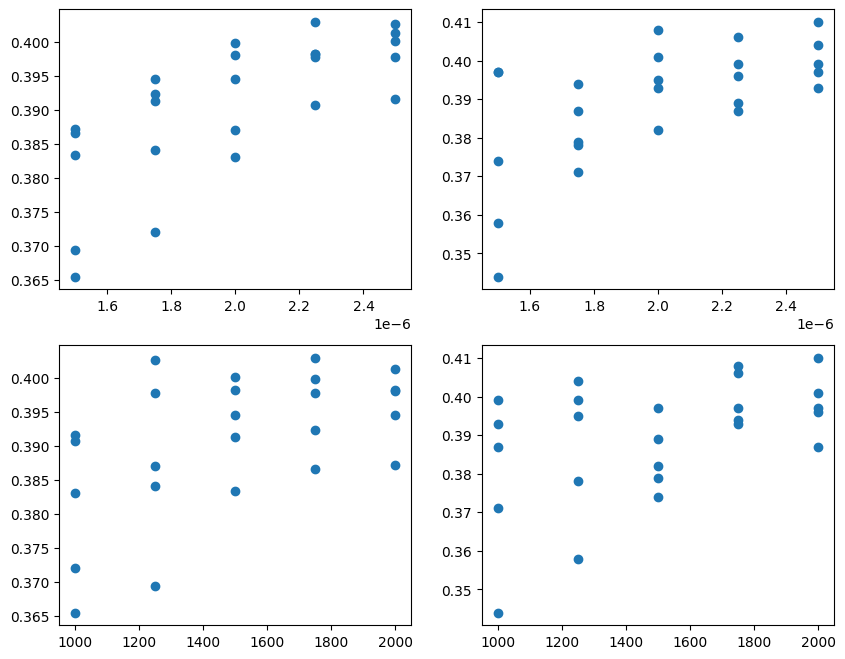

In [14]:
plt.subplot(2,2,1)
x = [lr for lr,reg in results]
y = [res[0] for res in results.values()]
plt.scatter(x,y)

plt.subplot(2,2,2)
x = [lr for lr,reg in results]
y = [res[1] for res in results.values()]
plt.scatter(x,y)

plt.subplot(2,2,3)
x = [reg for lr,reg in results]
y = [res[0] for res in results.values()]
plt.scatter(x,y)

plt.subplot(2,2,4)
x = [reg for lr,reg in results]
y = [res[1] for res in results.values()]
plt.scatter(x,y)


In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.391000


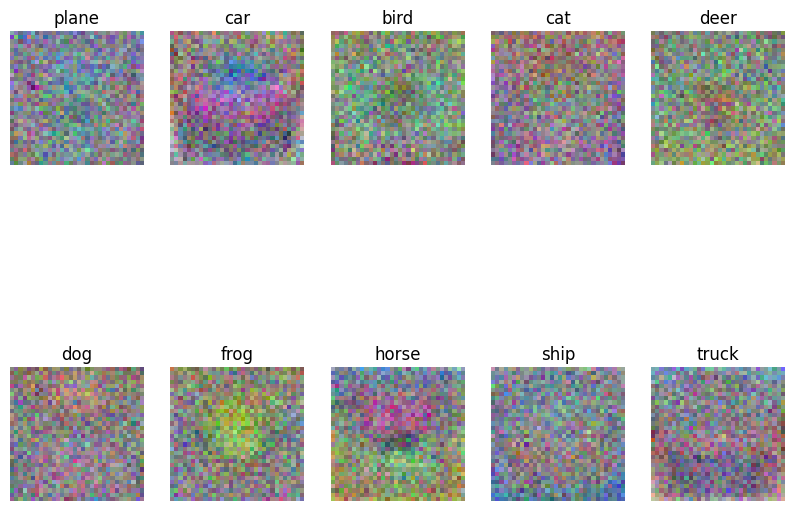

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])